#SPARC - The modified spectral arc length smoothness measure
---

This iPython notebook contains the details of the analysis carried out for the paper titled _"On the analysis of movement smoothness"_ [1] submitted to JNER as part of the STARS framework of the COST Action TD1009.

This notebook presents the work carried out for the development and evaluation of the properties SPARC (**SP**ectral **ARC** length), a modified version of the original spectral arc length presented in [2].

**Note**: Please execute the penultimate cell before executing any of the other cells.

**Requirements**: The following modules are required for the notebook to be executed: 
1. seaborn
2. pyprind

# Problem with the original Spectral Arc Length measure.
---

The orignal spectal arc length (SAL) measure is sensitive to changes in temporal scaling of a movement, i.e. the smoothness estimates of movements $x(t)$ and $x(at), a \neq 0$ will be different. This is demonstrated through a simulation analysis where the smoothness of Guassian movements of different durations are compared.

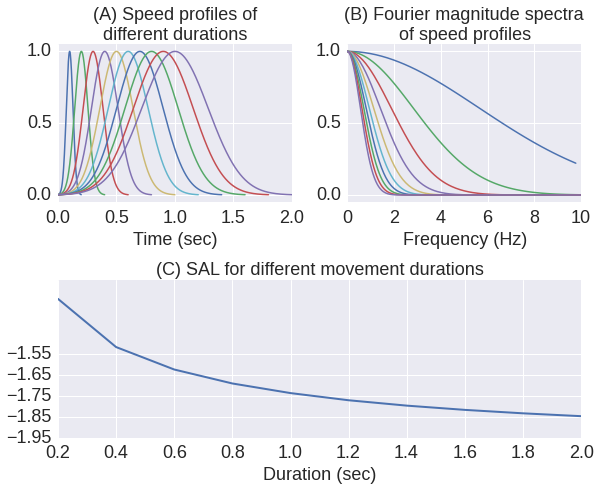

In [4]:
# Guassian movement parameters.
ts = 0.001
amp = 1.0
dur = np.linspace(0.2, 2.0, num=10)
loc = dur / 2.0
times = [np.arange(0., _d, ts) for _d in dur]

# Index of movement with duration 1 sec
dur_inx = np.nonzero(dur == 1.0)[0][0]

# Gaussian movements
moves = [gaussian_dm(amp=amp, 
                     dur=dur[i],
                     loc=loc[i], 
                     time=times[i]) for i in xrange(len(dur))]


# Estimate smoothness using SAL.
sal = np.zeros(len(dur))
_spec = [0] * len(dur)

# The SPARC function is used to estimate smoothness. The SPARC is equal to the 
# SAL when the amp_th is set to zero, and fc is set to 20Hz.
for i in xrange(0, len(dur)):
    sal[i], _, _spec[i] = sparc(moves[i], fs=1/ts, padlevel=4, fc=10., amp_th=0.0)
    
# Plot data.
fig = figure(figsize=(8.5,7))
# speed profile plot
subplot2grid(shape=(2,2), loc=(0,0), rowspan=1, colspan=1)
for i in xrange(0, len(dur), 1):
    plot(times[i], moves[i], lw=1.5)
ylim(-0.05, 1.05)
title('(A) Speed profiles of\ndifferent durations', fontsize=18)
xlabel('Time (sec)', fontsize=18)
xticks(fontsize=18)
yticks([0., 0.5, 1.0], fontsize=18)

# Fourier spectrum plot.
subplot2grid(shape=(2,2), loc=(0,1), rowspan=1, colspan=1)
for i in xrange(0, len(dur), 1):
    plot(_spec[i][0], _spec[i][1], lw=1.5)
ylim(-0.05, 1.05)
title('(B) Fourier magnitude spectra\nof speed profiles', fontsize=18)
xlabel('Frequency (Hz)', fontsize=18)
xticks(fontsize=18)
yticks([0., 0.5, 1.0], fontsize=18)

# Change of SAL with movement duration.
subplot2grid(shape=(2,2), loc=(1,0), rowspan=1, colspan=2)
plot(dur, sal, lw=2)  #plot(dur, sal - sal[dur_inx], lw=2)
title('(C) SAL for different movement durations', fontsize=18)
xlabel('Duration (sec)', fontsize=18)
xticks(fontsize=18)
yticks(np.arange(-1.95, -1.5, 0.1), fontsize=18)

tight_layout()

# Save figure.
fig.savefig('img/sal_problem.png', format='png', dpi=600)
fig.savefig('img/sal_problem.svg', format='svg', dpi=600)
fig.savefig('img/sal_problem.eps', format='eps', dpi=600)

# Demonstration of the problem with the SAL with a general set of movement data
---

The above problems can also be demonstrated on any general discrete movement consisting of several submovements. For this purpose, a library discrete movements were generated using the following submovement model for discrete movements,

$$ v(t) = \sum_{k=1}^{N_s} A_k e^{-25\left(\frac{t-\Delta T_k}{T_k}\right)^2} $$

where, $v(t)$ represents the movement speed profile, $N_s$ is the number of submovements in $x(t)$, $A_k$ is the amplitude of the $k^{th}$ submovement, $\Delta T_k$ is the inter-submovement interval of the $k^{th}$ submovement with respect to the $(k-1)^{th}$ submovement (where, $\Delta T_1 = 0$), and $T_k$ is the duration of the $k^{th}$ submovement. The values of these parameters are sampled from the following ranges using a uniform distribution.

| Parameter | Parameter Range 
| :- |:-------------:
| Number of submovements, $N_s \in \mathbb{N}^+$ | $\left[2, 10\right]$
| Submovement amplitude, $A_k \in \mathbb{R}$ | $\left[0.1, 1.0 \right]$
| Inter-submovement interval, $\Delta T_k \in \mathbb{R}$ | $\left(0, 1.0\right]$
| Submovement duration, $T_k \in \mathbb{R}$ | $\left[0.2, 1.0\right]$

The movement set generated using the above model was then used to generated three other temporally scaled data sets $v(2t)$, $v(4t)$ and $v(8t)$. The smoothness values of these different scaled data sets were compared. 

In [2]:
# Simulation parameters.
param = {}

# Total number of movements in the library
param['N_m'] = 1000

# Generate a set of movement parameters.
param['Ns'] = np.random.randint(2, 10, size=param['N_m'])
param['amps'] = [0.9 * np.random.rand(_n) + 0.1 for _n in param['Ns']]
param['dTs'] = [np.random.rand(_n-1) for _n in param['Ns']]
param['Ts'] = [0.8 * np.random.rand(_n) + 0.2 for _n in param['Ns']]

# Sampling time
ts = 0.001

# Scale factors.
scales = np.array([1.0, 2.0, 4.0, 8.0])

# Generate the library of movement for each scale.
moves = [0] * len(scales)
sal_vals = np.zeros((len(scales), param['N_m']))
sparc_vals = np.zeros((len(scales), param['N_m']))

# progress bad indicator.
bar = pyprind.ProgBar(param['N_m'] * len(scales), monitor=True)
for i in xrange(len(scales)):
    # Generate movements.
    moves[i] = [0] * param['N_m']
    for j in xrange(param['N_m']):
        # Generate movement
        _, moves[i][j], _ = gen_move(Ns=param['Ns'][j],
                                     amp=param['amps'][j],
                                     dT=scales[i] * param['dTs'][j],
                                     T=scales[i] * param['Ts'][j],
                                     ts=ts)
        # Estimate smoothness with SAL and SPARC.
        sal_vals[i,j], _, _ = sparc(moves[i][j], fs=1/ts, padlevel=4, fc=20., amp_th=0.0)
        sparc_vals[i,j], _, _ = sparc(moves[i][j], fs=1/ts, padlevel=4, fc=20., amp_th=0.05)
        bar.update()

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 637.707 sec


In [3]:
# Save generated data.
np.savez_compressed('sal_sparc_compare',
                    scales=scales,
                    ts=ts,
                    moves=moves,
                    sal=sal_vals,
                    sparc=sparc_vals,
                    **param)

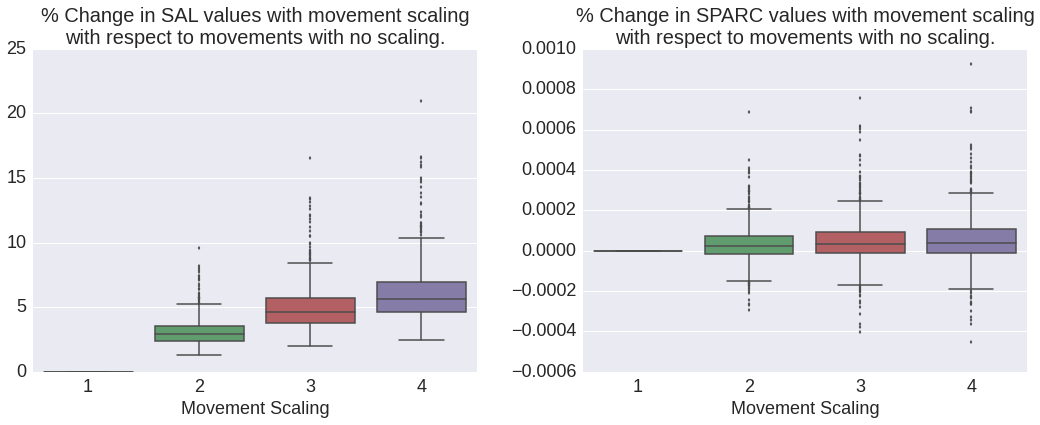

In [5]:
# Compare SAL and SPARC for different movements scales.
temp1 = np.zeros(sal_vals.shape)
temp2 = np.zeros(sparc_vals.shape)
for i in xrange(1, temp1.shape[0]):
    temp1[i, :] = 100 * (sal_vals[i, :] - sal_vals[0, :]) / sal_vals[0, :]
    temp2[i, :] = 100 * (sparc_vals[i, :] - sparc_vals[0, :]) / sal_vals[0, :]

fig = figure(figsize=(15,6))
subplot(121)
seaborn.boxplot(np.transpose(temp1))
title('% Change in SAL values with movement scaling\nwith respect to movements with no scaling.', fontsize=20)
xlabel('Movement Scaling', fontsize=18)
xticks(fontsize=18)
yticks(fontsize=18)

subplot(122)
seaborn.boxplot(np.transpose(temp2))
title('% Change in SPARC values with movement scaling\nwith respect to movements with no scaling.', fontsize=20)
xlabel('Movement Scaling', fontsize=18)
xticks(fontsize=18)
yticks(fontsize=18)

tight_layout()

# Save figure.
fig.savefig('img/sparc_correction.png', format='png')
fig.savefig('img/sparc_correction.svg', format='svg')

#Demonstration of the problem of threshold selection
---

The following simulation demonstrates the problem of selection of the threshold for the SPARC method. Three different movements are considered:
1. Movement with a Gaussian speed profile  of duration 1 sec
2. Movement with a Gaussian speed profile of duratiopn 0.5sec
3. Movement consisting of two Gaussian speed profiles.
4. Movement consisting of two Gaussian speed profile, along with additive noise.

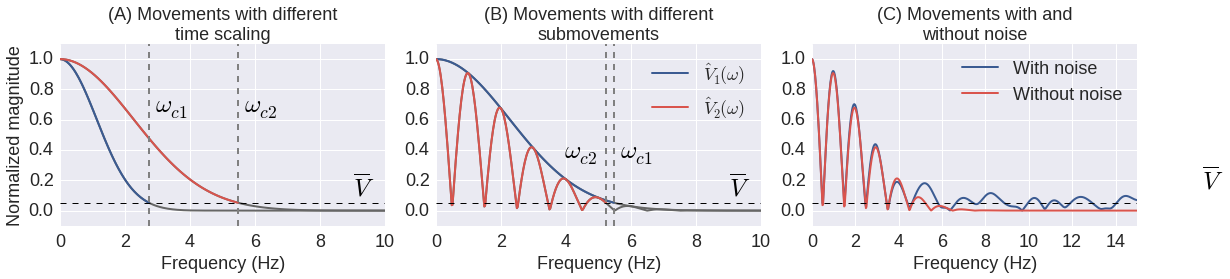

In [92]:
# Generate the four movements.
ts = 0.01
t1 = np.arange(0, 1, ts)
m1 = gaussian_dm(amp=1.0, dur=1.0, loc=0.5, time=t1)
t2 = np.arange(0, 0.5, ts)
m2 = gaussian_dm(amp=1.0, dur=0.5, loc=0.25, time=t2)
t3 = np.arange(0, 1.5, ts)
m3 = (gaussian_dm(amp=1.0, dur=0.5, loc=0.25, time=t3) + 
      gaussian_dm(amp=1.0, dur=0.5, loc=1.25, time=t3))
t4 = np.arange(0, 1.5, ts)
m4 = (gaussian_dm(amp=1.0, dur=0.5, loc=0.25, time=t3) + 
      gaussian_dm(amp=1.0, dur=0.5, loc=1.25, time=t3) +
      0.2 * np.random.randn(len(t4)))

# SPARC
_, Mf1, Mp1 = sparc(m1, fs=1/ts, padlevel=4, fc=10., amp_th=0.05)
_, Mf2, Mp2 = sparc(m2, fs=1/ts, padlevel=4, fc=10., amp_th=0.05)
_, Mf3, Mp3 = sparc(m3, fs=1/ts, padlevel=4, fc=10., amp_th=0.05)
_, Mf4, Mp4 = sparc(m4, fs=1/ts, padlevel=4, fc=10., amp_th=0.05)

# Text font.
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 25,
        }

fig = figure(figsize=(16,4))
subplot(131)
plot(Mf1[0], Mf1[1], lw=2, color='0.4')
plot(Mp1[0], Mp1[1], lw=2, color=seaborn.xkcd_rgb["denim blue"])
plot(Mf2[0], Mf2[1], lw=2, color='0.4')
plot(Mp2[0], Mp2[1], lw=2, color=seaborn.xkcd_rgb["pale red"])
plot([0, Mf1[0][-1]], [0.05, 0.05], 'k', linestyle='--', lw=1)
plot([Mp1[0][-1], Mp1[0][-1]], [-0.1, 1.1], '0.5', linestyle='--', lw=2)
plot([Mp2[0][-1], Mp2[0][-1]], [-0.1, 1.1], '0.5', linestyle='--', lw=2)
plt.text(9.0, 0.1, r'$\overline{V}$', font)
plt.text(Mp1[0][-1] + 0.2, 0.65, r'$\omega_{c1}$', font)
plt.text(Mp2[0][-1] + 0.2, 0.65, r'$\omega_{c2}$', font)
title("(A) Movements with different\ntime scaling", fontsize=18)
xlim(0, 10.)
ylim(-0.1, 1.1)
ylabel("Normalized magnitude", fontsize=18)
xlabel("Frequency (Hz)", fontsize=18)
xticks(fontsize=18)
yticks(fontsize=18)
subplot(132)
plot(Mf2[0], Mf2[1], lw=2, color='0.4')
plot(Mp2[0], Mp2[1], lw=2, color=seaborn.xkcd_rgb["denim blue"], label=r'$\hat{V}_{1}(\omega)$')
plot(Mf3[0], Mf3[1], lw=2, color='0.4')
plot(Mp3[0], Mp3[1], lw=2, color=seaborn.xkcd_rgb["pale red"], label=r'$\hat{V}_{2}(\omega)$')
plot([0, Mf1[0][-1]], [0.05, 0.05], 'k', linestyle='--', lw=1)
plot([Mp2[0][-1], Mp2[0][-1]], [-0.1, 1.1], '0.5', linestyle='--', lw=2)
plot([Mp3[0][-1], Mp3[0][-1]], [-0.1, 1.1], '0.5', linestyle='--', lw=2)
plt.text(9.0, 0.1, r'$\overline{V}$', font)
plt.text(Mp2[0][-1] + 0.2, 0.35, r'$\omega_{c1}$', font)
plt.text(Mp3[0][-1] - 1.3, 0.35, r'$\omega_{c2}$', font)
title("(B) Movements with different\nsubmovements", fontsize=18)
xlim(0, 10.)
ylim(-0.1, 1.1)
xlabel("Frequency (Hz)", fontsize=18)
xticks(fontsize=18)
yticks(fontsize=18)
legend(fontsize=18)
subplot(133)
plot(Mf4[0], Mf4[1], lw=2, color=seaborn.xkcd_rgb["denim blue"], label="With noise")
plot(Mf3[0], Mf3[1], lw=2, color=seaborn.xkcd_rgb["pale red"], label="Without noise")
plot([0, Mf1[0][-1]], [0.05, 0.05], 'k', linestyle='--', lw=1)
plt.text(18.0, 0.15, r'$\overline{V}$', font)
title("(C) Movements with and\nwithout noise", fontsize=18)
xlim(0, 15.)
ylim(-0.1, 1.1)
xlabel("Frequency (Hz)", fontsize=18)
xticks(fontsize=18)
yticks(fontsize=18)
legend(fontsize=18)
tight_layout()

# Save figure.
fig.savefig('img/sparc_th_selection.png', format='png', dpi=600)
fig.savefig('img/sparc_th_selection.svg', format='svg', dpi=600)
fig.savefig('img/sparc_th_selection.eps', format='eps', dpi=600)

# Validation of SPARC
---

This is a simply validation of the SPARC method using a set of simulated movements consists of different number of submovements of the same duration, and amplitude, but varying in number of inter-submovement interval.

The simulated movement data was generated using the following model,

$$ v(t) = \sum_{k=1}^{N_s} e^{-25\left(\frac{t-k\Delta T}{T}\right)^2} $$

where, $v(t)$ represents the movement speed profile, $N_s$ is the number of submovements in $x(t)$, $\Delta T$ is the inter-submovement interval between two successive submovements, and $T$ is the duration of the submovements. The values of these parameters are listed below.

| Parameter | Parameter Range 
| :- |:-------------:
| Number of submovements, $N_s$ | $\left[1, 10\right]$
| Inter-submovement interval, $\Delta T$ | $\left[0, 2.0\right]$
| Submovement duration, $T$ | $1.0$

In [19]:
# Simulation parameters.
param = {}

# Generate a set of movement parameters.
param['Ns'] = range(2, 21)
param['dT'] = np.arange(0, 2.1, 0.1)
param['T'] = 1.0

# Sampling time
ts = 0.001

moves = []

# Generate movements.
for ns in param['Ns']:
    _tmp =[]
    for dt in param['dT']:
        _, m, _ = gen_move(ns, np.ones(ns), dt * np.ones(ns-1), param['T'] * np.ones(ns))
        _tmp.append(m)
    moves.append(_tmp)

# Estimate SPARC smoothness.
sparc_val = np.zeros((len(param['Ns']), len(param['dT'])))
for i in xrange(len(param['Ns'])):
    for j in xrange(len(param['dT'])):
        sparc_val[i, j], _, _ = sparc(moves[i][j], fs=1/ts, padlevel=4, fc=10., amp_th=0.05)

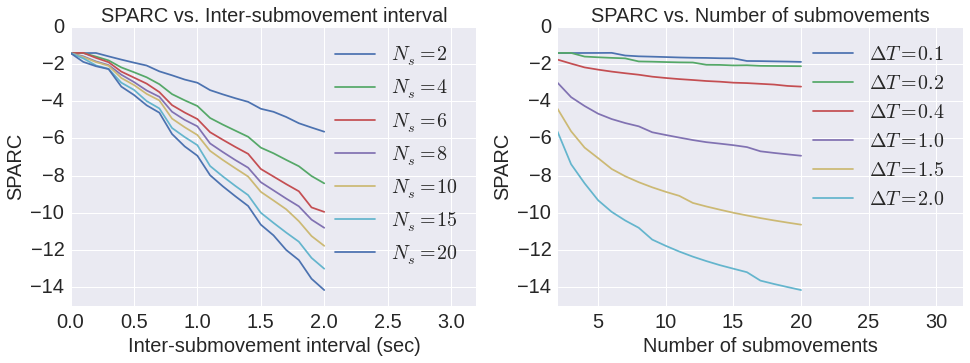

In [22]:
fig = figure(figsize=(16,5))
# Smoothness versus Intersubmovement .
N = [2, 4, 6, 8, 10, 15, 20]
subplot(121)
for ns in N:
    plot(param['dT'], sparc_val[ns-2, :], label="$N_s={0}$".format(ns))

xlim(0, 3.2)
ylim(-15, 0)
xlabel('Inter-submovement interval (sec)', fontsize=20)
ylabel('SPARC', fontsize=20)
xticks(fontsize=20)
yticks(fontsize=20)
legend(fontsize=20)
title('SPARC vs. Inter-submovement interval', fontsize=20)

subplot(122)
# Smoothness versus Number of submovements.
dT = [int(np.round(_dt/0.1)) for _dt in [0.1, 0.2, 0.4, 1.0, 1.5, 2.0]]
subplot(122)
for dt in dT:
    plot(param['Ns'], sparc_val[:, dt], label="$\Delta T={0}$".format(param['dT'][dt]))

xlim(2, 32)
ylim(-15, 0)
xlabel('Number of submovements', fontsize=20)
ylabel('SPARC', fontsize=20)
xticks(fontsize=20)
yticks(fontsize=20)
legend(fontsize=20)
title('SPARC vs. Number of submovements', fontsize=20);

# Save figure.
fig.savefig('img/sparc_sim_demo.png', format='png', dpi=600)
fig.savefig('img/sparc_sim_demo.svg', format='svg', dpi=600)
fig.savefig('img/sparc_sim_demo.eps', format='eps', dpi=600)

#Effect of noise on SPARC and LDLJ
---

This simulation estimates the effect of noise on the SPARC nad LDLJ measures. This simulation is performed by generating a library of 100 movements, to which 100 different realization of white noise of different SNR (1000, 100, 10, 1) are added. The smoothness of the data with and without noise are estimated, and the effect of noise is quantified by looking at the smooth histogram of the normalized difference in the smoothness estimate between the data with and without noise.

To ensure a fair comparison between the SPARC and the LDLJ, the noisy data are filtered forward and backward using a lowpass filter. The performance of the LDLJ measure is most likely dependent on the filter characteristics. TO investigate this, four different lowpass Butterworth filters were tested.

In [2]:
# Generate a library of 100 movements.
# Simulation parameters.
param = {}

# Total number of movements in the library
param['N_m'] = 100
param['N_n'] = 25

# Generate a set of movement parameters.
param['Ns'] = np.random.randint(1, 10, size=param['N_m'])
param['amps'] = [0.9 * np.random.rand(_n) + 0.1 for _n in param['Ns']]
param['dTs'] = [0.75 * np.random.rand(_n-1) for _n in param['Ns']]
param['Ts'] = [0.8 * np.random.rand(_n) + 0.2 for _n in param['Ns']]
param['snr'] = [1000, 100, 10, 1]

# Sampling time
ts = 0.001

In [3]:
# Filter parameters
filt_param = filter_parameters(1./ts)

# Ideal movements.
ideal_moves = generate_ideal_movements(param)

# Noisy movements.
noisy_moves = generate_noisy_movements(ideal_moves, param)

# Filtered movements.
filt_moves = filter_noisy_movements(noisy_moves, param, filt_param)

...

In [5]:
# Estimate smoothness of the different movements.
sparc_ideal = est_smooth_ideal(ideal_moves, ts, 'sparc')
sparc_noisy = est_smooth_noisy(noisy_moves, ts, param, 'sparc')
sparc_filt = est_smooth_filt(filt_moves, ts, param, filt_param, 'sparc')
ldlj_ideal = est_smooth_ideal(ideal_moves, ts, 'ldlj')
ldlj_noisy = est_smooth_noisy(noisy_moves, ts, param, 'ldlj')
ldlj_filt = est_smooth_filt(filt_moves, ts, param, filt_param, 'ldlj')

......

##Comparison of SPARC and LDLJ without filtering (Normalizaition with respect to the ideal smoothness value).

The comparison is done by calculating the normalized difference between the ideal and the noisy smoothness estimates. The normalization is done with respect to the ideal value.

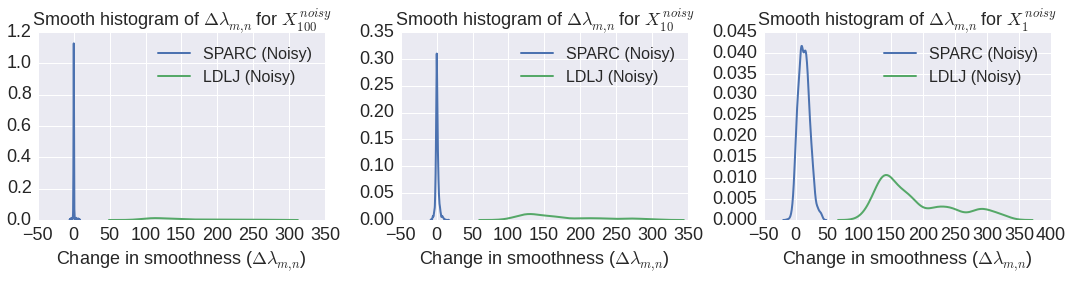

In [6]:
# % change in smoothness because of noise and filtering.
dnoise_sparc = est_change_noisy(sparc_noisy, sparc_ideal, param)
dnoise_ldlj = est_change_noisy(ldlj_noisy, ldlj_ideal, param)

# Plot the results of the noise analysis.
_ylims = (110, 40, 5)
fig = figure(figsize=(15, 4))
for _snr in xrange(1, len(param['snr'])):
    # flattended across noise data for histogram plots
    noise_sparc = np.zeros(0)
    noise_ldlj = np.zeros(0)
    for i in xrange(param['N_n']):
        noise_sparc = np.append(noise_sparc, dnoise_sparc[:, _snr, i])
        noise_ldlj = np.append(noise_ldlj, dnoise_ldlj[:, _snr, i])
    # plot data
    subplot(1, 3, _snr)
    seaborn.kdeplot(noise_sparc, lw=2, label="SPARC (Noisy)")
    seaborn.kdeplot(noise_ldlj, lw=2, label="LDLJ (Noisy)")
    xticks(fontsize=18)
    yticks(fontsize=18)
    legend(fontsize=16)
    xlabel(r'Change in smoothness ($\Delta \lambda_{{m,n}}$)', fontsize=18)
    title(r'Smooth histogram of $\Delta \lambda_{{m,n}}$ for $X_{{{0}}}^{{noisy}}$'.format(
            param['snr'][_snr]),fontsize=18)
    tight_layout()
    
# Save figure.
fig.savefig('img/rel_noise.png', format='png', dpi=600)
fig.savefig('img/rel_noise.svg', format='svg', dpi=600)
fig.savefig('img/rel_noise.eps', format='eps', dpi=600)

##Comparison of SPARC and LDLJ without filtering (Normalization with repsect to the range of smoothness values in the ideal data set).

The normalization was done with respect to the ideal smoothness value in the analysis above. But a more appropriate normalization factor would be the range of smoothness values in the ideal movement data set. The type of normalize would be similar to that of comparing the variances in smoothness introduced because of noise, with respect to that of the variance in the actual smoothness values in the ideal movement data set.

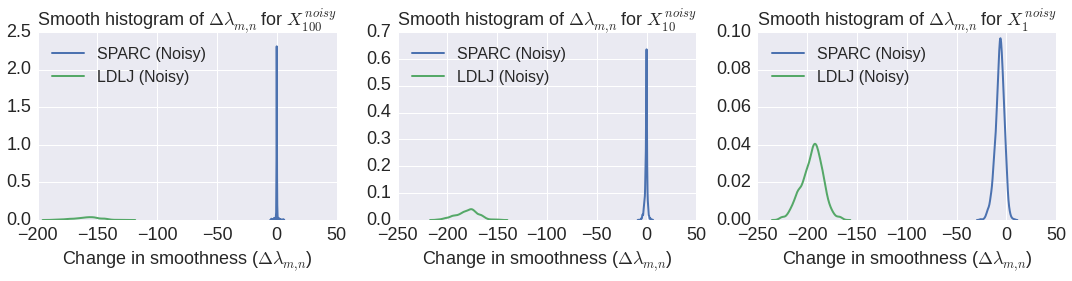

In [7]:
# % change in smoothness because of noise and filtering.
dnoise_sparc = est_change_noisy_wrt_range(sparc_noisy, sparc_ideal, param)
dnoise_ldlj = est_change_noisy_wrt_range(ldlj_noisy, ldlj_ideal, param)

# Plot the results of the noise analysis.
_ylims = (110, 40, 5)
fig = figure(figsize=(15, 4))
for _snr in xrange(1, len(param['snr'])):
    # flattended across noise data for histogram plots
    noise_sparc = np.zeros(0)
    noise_ldlj = np.zeros(0)
    for i in xrange(param['N_n']):
        noise_sparc = np.append(noise_sparc, dnoise_sparc[:, _snr, i])
        noise_ldlj = np.append(noise_ldlj, dnoise_ldlj[:, _snr, i])
    # plot data
    subplot(1, 3, _snr)
    seaborn.kdeplot(noise_sparc, lw=2, label="SPARC (Noisy)")
    seaborn.kdeplot(noise_ldlj, lw=2, label="LDLJ (Noisy)")
    xticks(fontsize=18)
    yticks(fontsize=18)
    legend(loc=2, fontsize=16)
    xlabel(r'Change in smoothness ($\Delta \lambda_{{m,n}}$)', fontsize=18)
    title(r'Smooth histogram of $\Delta \lambda_{{m,n}}$ for $X_{{{0}}}^{{noisy}}$'.format(
            param['snr'][_snr]),fontsize=18)
    tight_layout()
    
# Save figure.
fig.savefig('img/rel_noise_wrt_range.png', format='png', dpi=600)
fig.savefig('img/rel_noise_wrt_range.svg', format='svg', dpi=600)
fig.savefig('img/rel_noise_wrt_range.eps', format='eps', dpi=600)

## Comparison of SPARC and LDLJ after filtering (Normalizaition with respect to the ideal smoothness value).

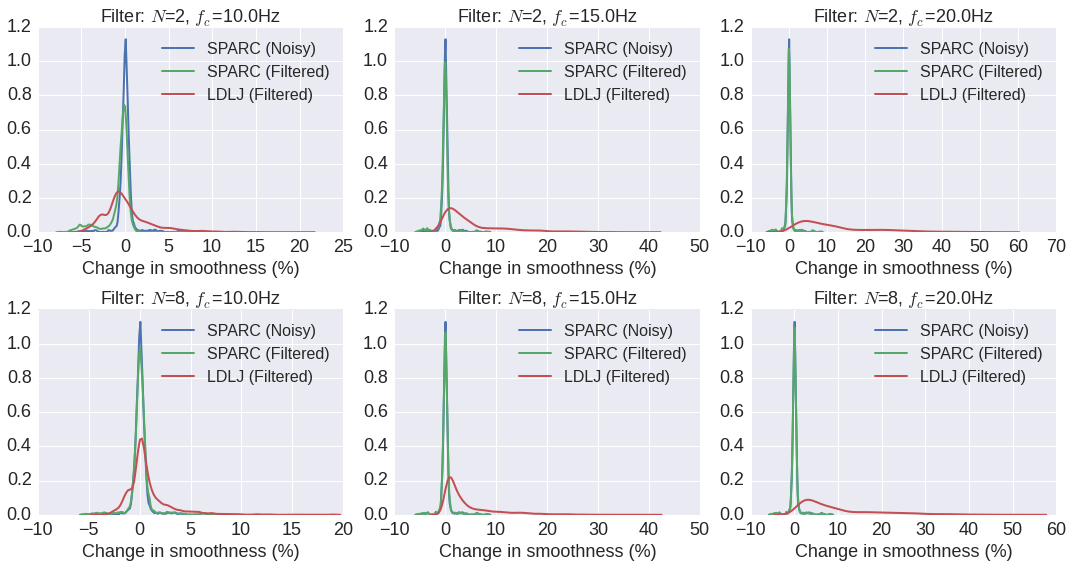

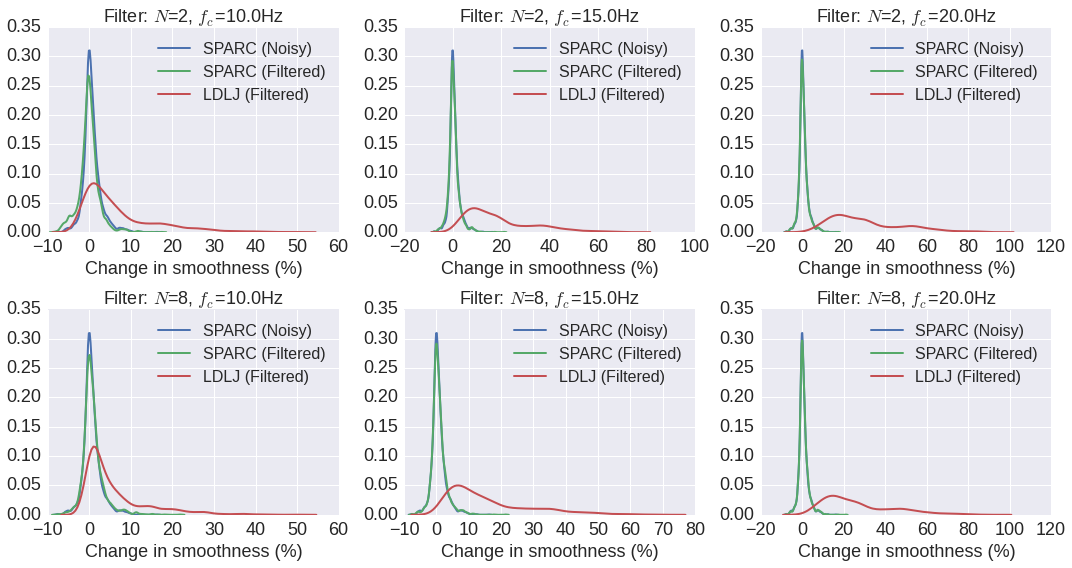

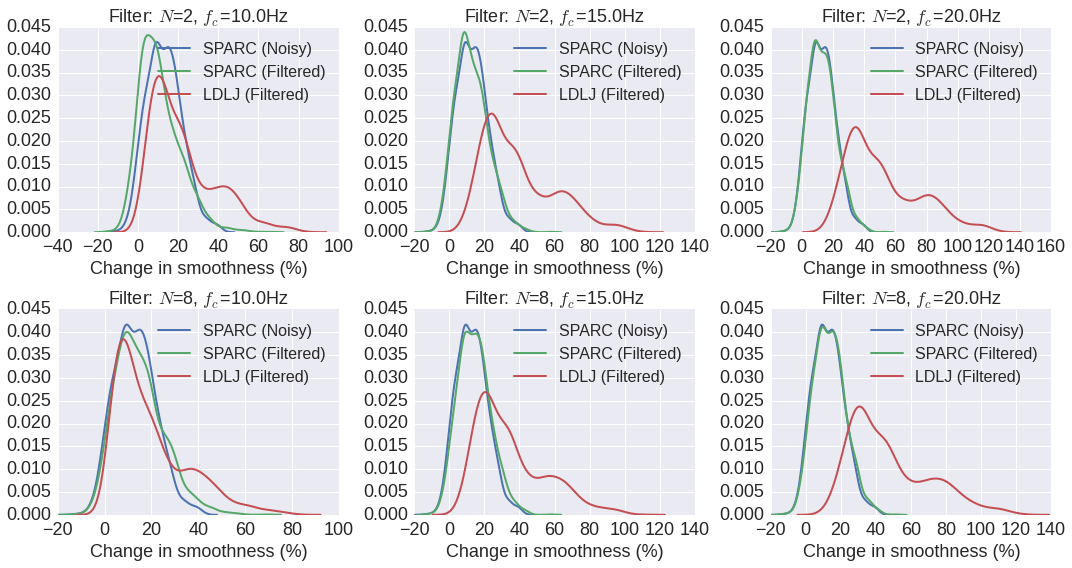

In [8]:
# % change in smoothness because of noise and filtering.
dnoise_sparc = est_change_noisy(sparc_noisy, sparc_ideal, param)
dfilt_sparc = est_change_filt(sparc_filt, sparc_ideal, param, filt_param)
dfilt_ldlj = est_change_filt(ldlj_filt, ldlj_ideal, param, filt_param)

# Plot the results of the noise analysis.
_ylims = (110, 40, 5)
for _snr in xrange(1, len(param['snr'])):
    fig = figure(figsize=(15, 8))
    for _n in xrange(len(filt_param['N'])):
        for _f in xrange(len(filt_param['fc'])):
            # flattended across noise data for histogram plots
            noise_sparc = np.zeros(0)
            filt_sparc = np.zeros(0)
            noise_ldlj = np.zeros(0)
            filt_ldlj = np.zeros(0)
            for i in xrange(param['N_n']):
                noise_sparc = np.append(noise_sparc, dnoise_sparc[:, _snr, i])
                filt_sparc = np.append(filt_sparc, dfilt_sparc[:, _snr, i, _n, _f])
                filt_ldlj = np.append(filt_ldlj, dfilt_ldlj[:, _snr, i, _n, _f])
            # plot data
            subplot(2, 3, 3*_n+_f+1)
            seaborn.kdeplot(noise_sparc, lw=2, label="SPARC (Noisy)")
            seaborn.kdeplot(filt_sparc, lw=2, label="SPARC (Filtered)")
            seaborn.kdeplot(filt_ldlj, lw=2, label="LDLJ (Filtered)")
            xticks(fontsize=18)
            yticks(fontsize=18)
            legend(fontsize=16)
            xlabel("Change in smoothness (%)", fontsize=18)
            title("Filter: $N$={0}, $f_c$={1}Hz".format(filt_param['N'][_n],
                                                        filt_param['fc'][_f]), fontsize=18)
    tight_layout()
    
    # Save figure.
    fig.savefig('img/rel_filt_snr={0}.png'.format(param['snr'][_snr]), format='png', dpi=600)
    fig.savefig('img/rel_filt_snr={0}.svg'.format(param['snr'][_snr]), format='svg', dpi=600)
    fig.savefig('img/rel_filt_snr={0}.eps'.format(param['snr'][_snr]), format='eps', dpi=600)

## Comparison of SPARC and LDLJ after filtering (Normalization with repsect to the range of smoothness values in the ideal data set).

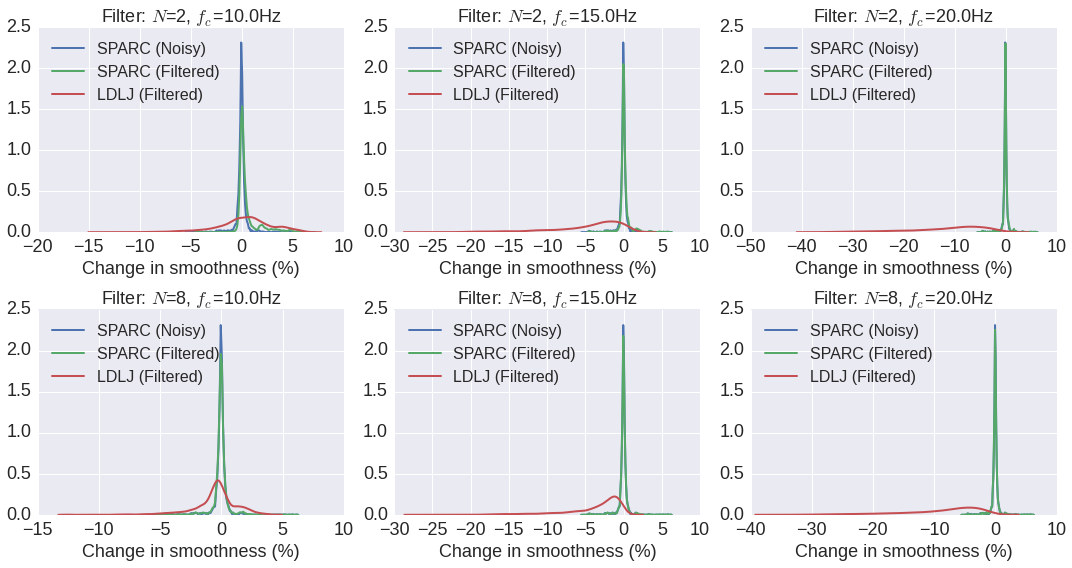

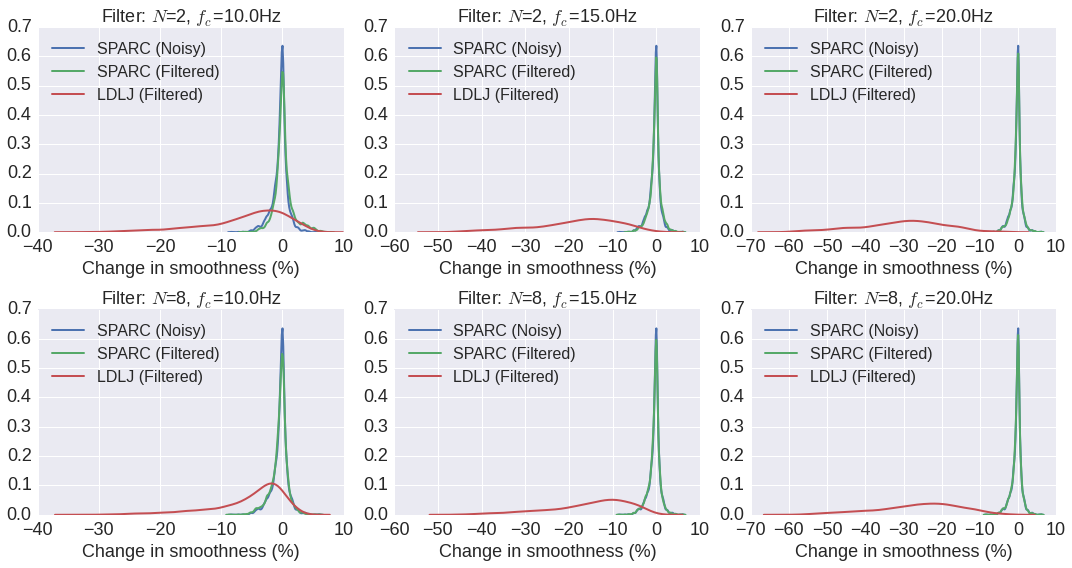

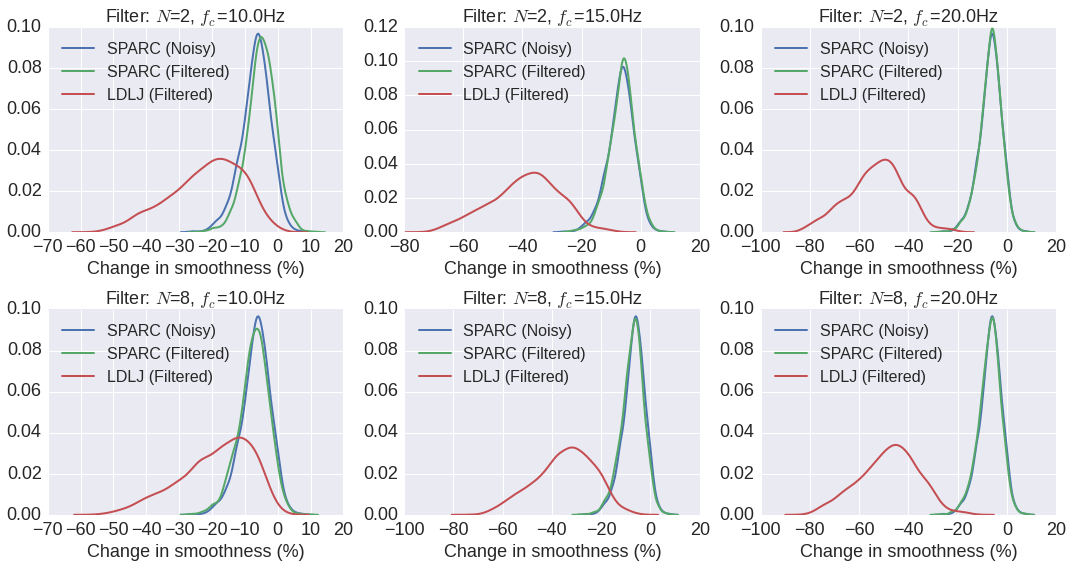

In [9]:
# % change in smoothness because of noise and filtering.
dnoise_sparc = est_change_noisy_wrt_range(sparc_noisy, sparc_ideal, param)
dfilt_sparc = est_change_filt_wrt_range(sparc_filt, sparc_ideal, param, filt_param)
dfilt_ldlj = est_change_filt_wrt_range(ldlj_filt, ldlj_ideal, param, filt_param)

# Plot the results of the noise analysis.
_ylims = (110, 40, 5)
for _snr in xrange(1, len(param['snr'])):
    fig = figure(figsize=(15, 8))
    for _n in xrange(len(filt_param['N'])):
        for _f in xrange(len(filt_param['fc'])):
            # flattended across noise data for histogram plots
            noise_sparc = np.zeros(0)
            filt_sparc = np.zeros(0)
            noise_ldlj = np.zeros(0)
            filt_ldlj = np.zeros(0)
            for i in xrange(param['N_n']):
                noise_sparc = np.append(noise_sparc, dnoise_sparc[:, _snr, i])
                filt_sparc = np.append(filt_sparc, dfilt_sparc[:, _snr, i, _n, _f])
                filt_ldlj = np.append(filt_ldlj, dfilt_ldlj[:, _snr, i, _n, _f])
            # plot data
            subplot(2, 3, 3*_n+_f+1)
            seaborn.kdeplot(noise_sparc, lw=2, label="SPARC (Noisy)")
            seaborn.kdeplot(filt_sparc, lw=2, label="SPARC (Filtered)")
            seaborn.kdeplot(filt_ldlj, lw=2, label="LDLJ (Filtered)")
            xticks(fontsize=18)
            yticks(fontsize=18)
            legend(loc=2, fontsize=16)
            xlabel("Change in smoothness (%)", fontsize=18)
            title("Filter: $N$={0}, $f_c$={1}Hz".format(filt_param['N'][_n],
                                                        filt_param['fc'][_f]), fontsize=18)
    tight_layout()
    
    # Save figure.
    fig.savefig('img/rel_filt_snr={0}_wrt_range.png'.format(param['snr'][_snr]), format='png', dpi=600)
    fig.savefig('img/rel_filt_snr={0}_wrt_range.svg'.format(param['snr'][_snr]), format='svg', dpi=600)
    fig.savefig('img/rel_filt_snr={0}_wrt_range.eps'.format(param['snr'][_snr]), format='eps', dpi=600)

#Effect of fixed power noise on movements of different durations
---

All measuring equiment can be assumed to have a fixed level of measurement noise. Under this condition, movements made at different speeds can affect smoothness estimates, as changes in SNR can lead to changes in smoothness estimates. In order to understand this, a set of movements were generated with two different scales, and noise of fixed power was added. The smoothness of the movements with different scales were quantified using both the SPARC and LDLJ measures. The data were filtered with a 8th order 10Hz lowpass Butterworth filter before estimating SPARC and LDLJ.

In [2]:
# Generate a library of 100 movements at two different scales.
# Simulation parameters.
param = {}

# Total number of movements in the library
param['N_m'] = 100

# Generate a set of movement parameters.
param['Ns'] = np.random.randint(1, 10, size=param['N_m'])
param['amps'] = [0.9 * np.random.rand(_n) + 0.1 for _n in param['Ns']]
param['dTs'] = [0.75 * np.random.rand(_n-1) for _n in param['Ns']]
param['Ts'] = [0.8 * np.random.rand(_n) + 0.2 for _n in param['Ns']]
param['scales'] = [1.0, 2.0]

# Sampling time
ts = 0.001

# Generate movements for the different scales.
moves = genenrate_different_scale_move(param)

In [21]:
# Noise variance
param['npower'] = 0.01

# Add noise to the data.
moves_noisy = add_noise(moves, param['npower'], param)

# Filter data.
moves_filt = filter_movements(moves_noisy, 1./ts, param)

# Estimate movement smoothness.
sparc_ideal = estimate_smoothness(moves, ts, param, 'sparc')
ldlj_ideal = estimate_smoothness(moves, ts, param, 'ldlj')
sparc_noise = estimate_smoothness(moves_noisy, ts, param, 'sparc')
ldlj_noise = estimate_smoothness(moves_noisy, ts, param, 'ldlj')
sparc_filt = estimate_smoothness(moves_filt, ts, param, 'sparc')
ldlj_filt = estimate_smoothness(moves_filt, ts, param, 'ldlj')

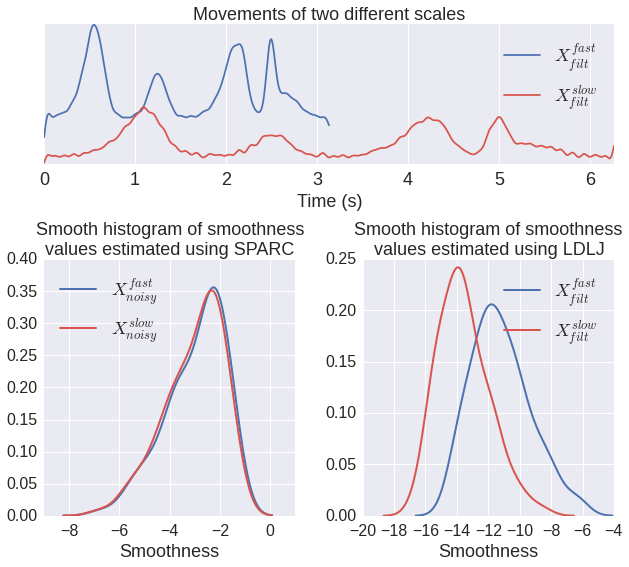

In [23]:
# Plot the smoothness of the movement of different scales.
i = 37
fig = figure(figsize=(9, 8))
subplot2grid((5, 2), (0, 0), colspan=2, rowspan=2)
t1 = np.arange(0, ts * len(moves_filt[0, i]), ts)
t2 = np.arange(0, ts * len(moves_filt[1, i]), ts)
plot(t1, moves_filt[0, i], label=r'$X_{filt}^{fast}$')
plot(t2, moves_filt[1, i] - 0.5, label=r'$X_{filt}^{slow}$', color=seaborn.xkcd_rgb["pale red"])
yticks([])
xticks(fontsize=18)
xlim([t2[0], t2[-1]])
xlabel("Time (s)", fontsize=18)
legend(fontsize=18)
title('Movements of two different scales', fontsize=18)

subplot2grid((5, 2), (2, 0), colspan=1, rowspan=3)
seaborn.kdeplot(sparc_noise[0], lw=2, label=r'$X_{noisy}^{fast}$')
seaborn.kdeplot(sparc_noise[1], lw=2, label=r'$X_{noisy}^{slow}$', color=seaborn.xkcd_rgb["pale red"])
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Smoothness', fontsize=18)
title('Smooth histogram of smoothness\nvalues estimated using SPARC', fontsize=18)
legend(loc=2, fontsize=18)

subplot2grid((5, 2), (2, 1), colspan=1, rowspan=3)
seaborn.kdeplot(ldlj_filt[0], lw=2, label=r'$X_{filt}^{fast}$')
seaborn.kdeplot(ldlj_filt[1], lw=2, label=r'$X_{filt}^{slow}$', color=seaborn.xkcd_rgb["pale red"])
legend(fontsize=18)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Smoothness', fontsize=18)
title('Smooth histogram of smoothness\nvalues estimated using LDLJ', fontsize=18)
tight_layout()

# Save figure.
fig.savefig('img/smooth_diff_scales_npower_{0}.png'.format(param['npower']), format='png', dpi=600)
fig.savefig('img/smooth_diff_scales_npower_{0}.svg'.format(param['npower']), format='svg', dpi=600)
fig.savefig('img/smooth_diff_scales_npower_{0}.eps'.format(param['npower']), format='eps', dpi=600)

In [1]:
# ~~~~~~~~~~~~~~~~~~~~ #
# INITIALIZATION       #
# --------------       #
# Run this cell first. #
# ~~~~~~~~~~~~~~~~~~~~ #
%pylab inline

import seaborn
from scipy import signal
import pyprind
import sys

sys.path.append("scripts")
from movements import gaussian_discrete_movement as gaussian_dm
from movements import generate_movement as gen_move
from smoothness import sparc
from smoothness import log_dimensionless_jerk as ldlj
from support import generate_ideal_movements
from support import generate_noisy_movements
from support import filter_parameters
from support import filter_noisy_movements
from support import est_smooth_ideal
from support import est_smooth_noisy
from support import est_smooth_filt
from support import est_change_noisy
from support import est_change_noisy_wrt_range
from support import est_change_filt
from support import est_change_filt_wrt_range
from support import genenrate_different_scale_move
from support import add_noise
from support import filter_movements
from support import estimate_smoothness

# mpl setting for saving SVG files.
mpl.rcParams['svg.fonttype'] = 'none'

Populating the interactive namespace from numpy and matplotlib


## Bibliography
[1] Balasubramanian, S., Melendez-Calderon, A., Roby-Brami, A., & Burdet, E. (2015). On the analysis of movement smoothness. _Journal of Neuroengineering and Rehabilitation_, Submitted.

[2] Balasubramanian, S., Melendez-Calderon, A., & Burdet, E. (2012). A robust and sensitive metric for quantifying movement smoothness. _Biomedical Engineering, IEEE Transactions on_, 59(8), 2126-2136.